In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
from pauli_mani import PauliPoly

In [3]:
## Arbitary Hamiltonian
qubits = 4
n_dim = int(2**qubits)
h_r = np.matrix(np.random.random((n_dim, n_dim)))
h_c = np.matrix(np.random.random((n_dim, n_dim)))
A_h = h_r + 1j*h_c
H = A_h.H@A_h

In [4]:
# Get eigen terms
evals, evectors = np.linalg.eig(H)
evals.real

array([1.30349929e+02, 6.81184616e+00, 6.00360287e+00, 5.42263370e+00,
       3.78288297e+00, 3.63078061e+00, 2.75142529e+00, 2.02637701e+00,
       1.56031178e+00, 1.32896407e+00, 8.03478621e-01, 3.74488545e-01,
       1.64251996e-02, 2.50505608e-01, 1.21967675e-01, 1.65492608e-01])

In [5]:
# Test the normality
for i in range(0, n_dim):
    print(np.linalg.norm(evectors[i]))

1.0000000000000033
0.999999999999997
1.0000000000000002
1.000000000000004
1.000000000000001
0.9999999999999988
0.9999999999999938
1.0000000000000013
1.0000000000000016
1.0000000000000047
0.9999999999999983
0.9999999999999976
0.999999999999998
0.999999999999999
1.0000000000000013
0.9999999999999994


In [6]:
# Orthogonal
evectors[0]@(evectors[1].H)

matrix([[1.05471187e-15+2.18575158e-15j]])

In [7]:
spectrum = [(e,ev)for e, ev in zip(evals.real, evectors)]

In [8]:
spectrum.sort()

In [9]:
# Spectrums
for e, v in spectrum:
    print(e)

0.016425199554546903
0.12196767533875005
0.16549260840786575
0.2505056077712877
0.37448854532033604
0.803478620844548
1.3289640739687862
1.5603117779057338
2.026377008556212
2.751425294686188
3.630780606111305
3.7828829685606915
5.422633704630232
6.003602874293515
6.811846156959234
130.34992927933024


## Decompose the given Hamiltonian

In [10]:
from copy import deepcopy

In [11]:
H_test = deepcopy(H)

In [12]:
ppoly = PauliPoly.from_matrix(H_test)
H_poly = ppoly.to_matrix()
# Find a state whose eigen vector decomposition is all eigen vector of Hamiltonian.
mixed_state = deepcopy(H_poly.sum(axis=1))
m_amp = np.sqrt((mixed_state.conj()*mixed_state).sum())
mixed_state /= m_amp

In [13]:
np.linalg.norm(mixed_state)

0.9999999999999999

In [14]:
mixed_state

array([0.23513175+0.01492016j, 0.23681164-0.02151025j,
       0.24938975+0.00102153j, 0.23029559+0.00805673j,
       0.22128957+0.00023588j, 0.25282604-0.03100425j,
       0.2099945 +0.00381265j, 0.25481588-0.03305248j,
       0.27949304+0.057348j  , 0.26190993-0.00528781j,
       0.26083389-0.01671567j, 0.24202478-0.03113919j,
       0.23174947+0.04140454j, 0.27269107-0.02390363j,
       0.2894342 +0.0029941j , 0.23571597+0.03281969j])

## Test with Imaginary VQE

In [15]:
from qiskit.quantum_info import SparsePauliOp

In [17]:
coefs, paulis =  ppoly.to_qiskit(sparse=False)

In [18]:
hamiltonian = SparsePauliOp(paulis, coefs)

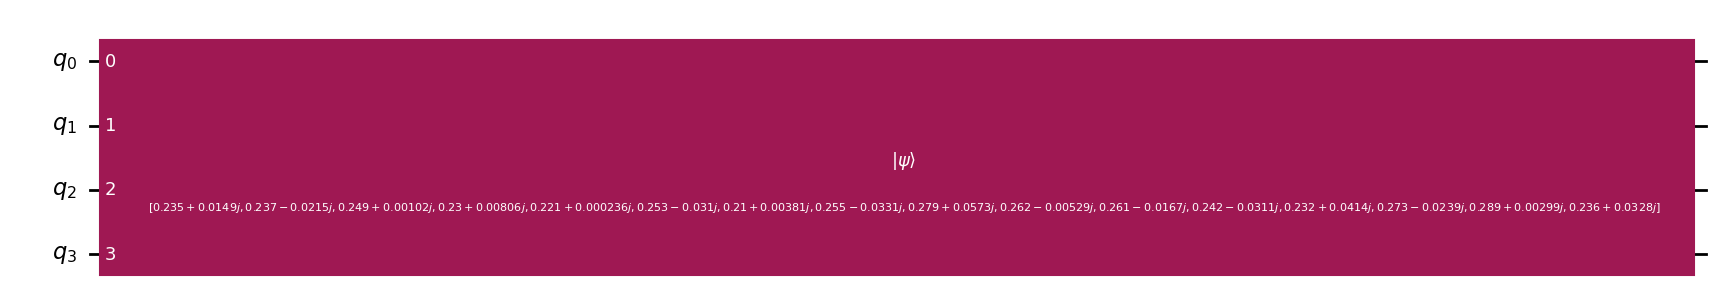

In [19]:
from qiskit.circuit.library import EfficientSU2
from qiskit import QuantumCircuit
import numpy as np


qc = QuantumCircuit(hamiltonian.num_qubits)
qc.initialize(mixed_state, range(hamiltonian.num_qubits))
qc.draw("mpl")


In [20]:
ansatz = EfficientSU2(
    hamiltonian.num_qubits, reps=1, 
    initial_state=qc) # Initial state is a forward circuit.
ansatz.parameters

ParameterView([ParameterVectorElement(θ[0]), ParameterVectorElement(θ[1]), ParameterVectorElement(θ[2]), ParameterVectorElement(θ[3]), ParameterVectorElement(θ[4]), ParameterVectorElement(θ[5]), ParameterVectorElement(θ[6]), ParameterVectorElement(θ[7]), ParameterVectorElement(θ[8]), ParameterVectorElement(θ[9]), ParameterVectorElement(θ[10]), ParameterVectorElement(θ[11]), ParameterVectorElement(θ[12]), ParameterVectorElement(θ[13]), ParameterVectorElement(θ[14]), ParameterVectorElement(θ[15])])

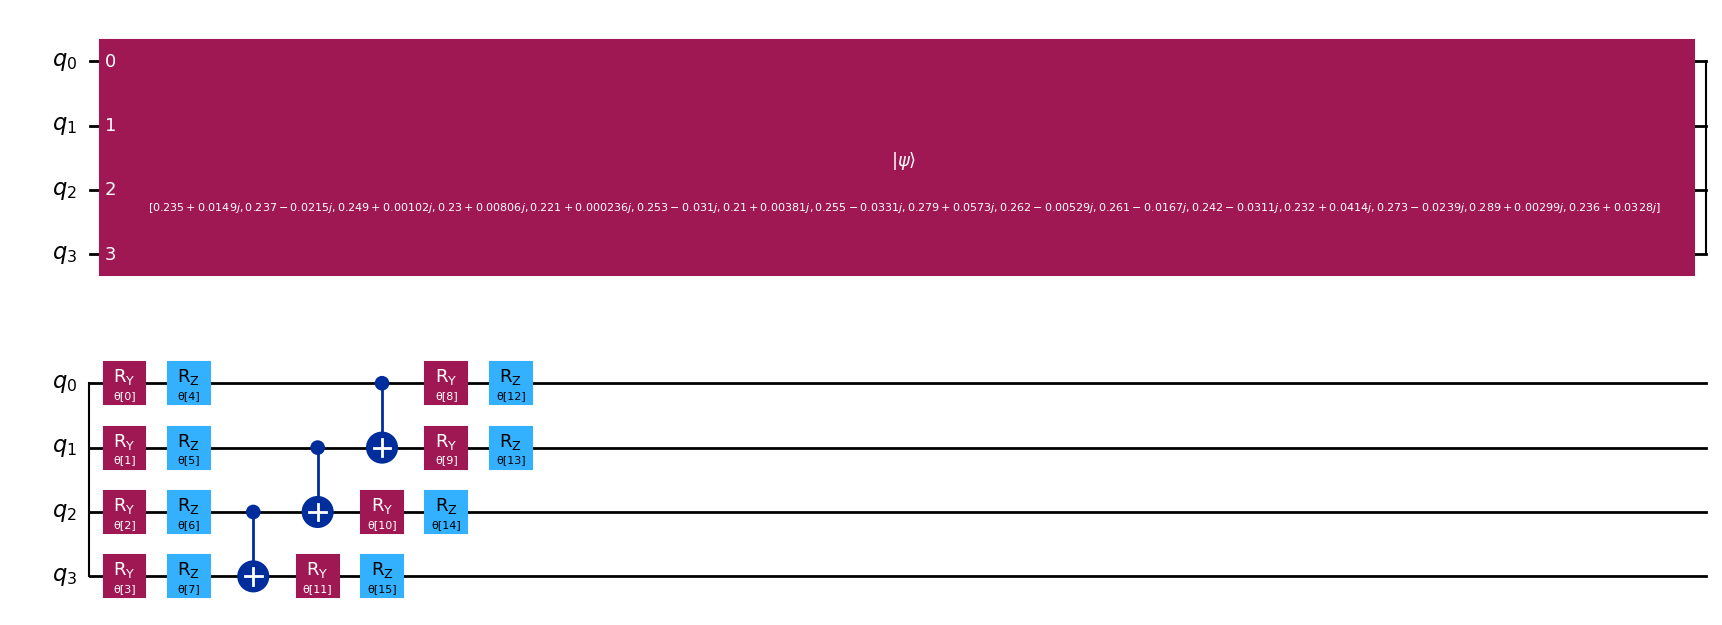

In [21]:
ansatz.decompose().draw("mpl")

In [22]:
init_param_values = {}
for i in range(len(ansatz.parameters)):
    init_param_values[ansatz.parameters[i]] = np.pi / 2

In [23]:
from qiskit_algorithms.time_evolvers.variational import ImaginaryMcLachlanPrinciple
from qiskit_algorithms import TimeEvolutionProblem
from qiskit_algorithms.gradients import ReverseEstimatorGradient, ReverseQGT

In [42]:
var_principle = ImaginaryMcLachlanPrinciple()
time = 8.0
aux_ops = [hamiltonian]
evolution_problem = TimeEvolutionProblem(hamiltonian, time, aux_operators=aux_ops)

In [43]:
from qiskit_algorithms import VarQITE
from qiskit.primitives import Estimator

In [44]:
var_qite = VarQITE(ansatz, init_param_values, var_principle, Estimator())
# an Estimator instance is necessary, if we want to calculate the expectation value of auxiliary operators.
evolution_result = var_qite.evolve(evolution_problem)

In [45]:
import pylab

In [46]:
np.linalg.eigvals(H_poly).real

array([1.30349929e+02, 6.81184616e+00, 6.00360287e+00, 5.42263370e+00,
       3.78288297e+00, 3.63078061e+00, 2.75142529e+00, 2.02637701e+00,
       1.56031178e+00, 1.32896407e+00, 8.03478621e-01, 3.74488545e-01,
       1.64251996e-02, 2.50505608e-01, 1.21967675e-01, 1.65492608e-01])

130.34992927933038
6.811846156959237
6.0036028742935175
5.422633704630233
3.782882968560693
3.630780606111309
2.751425294686183
2.0263770085562163
1.5603117779057343
1.3289640739687876
0.8034786208445489
0.37448854532033615
0.016425199554548825
0.2505056077712875
0.12196767533875023
0.16549260840786595


(-0.3, 3.0)

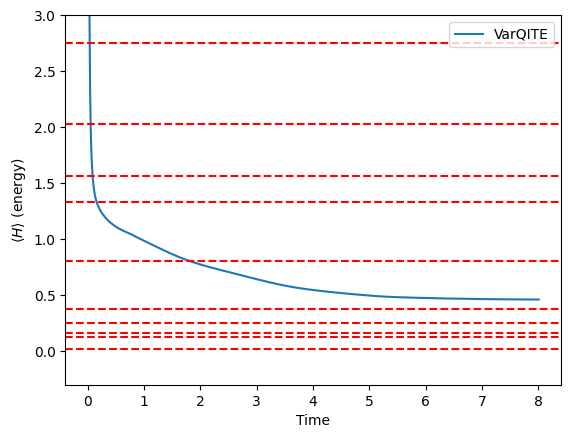

In [47]:
h_exp_val = np.array([ele[0][0] for ele in evolution_result.observables])
times = evolution_result.times
pylab.plot(times, h_exp_val, label="VarQITE")
pylab.xlabel("Time")
pylab.ylabel(r"$\langle H \rangle$ (energy)")
pylab.legend(loc="upper right")

for e in np.linalg.eigvals(H_poly).real:
    print(e)
    pylab.axhline(y=e, xmin=0, xmax=time, linestyle="--", c= "r")
pylab.ylim(-0.3, 3)

## Implement Spectrum Search Algorithm

In [15]:
## Quantum Circuit
import qiskit
from qiskit.circuit.library import StatePreparation
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit
from qiskit_algorithms import 

In [ ]:
def get_resources(mix_state, known_states):
        n = mix_state.size
        # sum known_state
        # nomarlization

        M0 = 
        Hw = np.identity(n) - 
        H0 = np.identity(n)
        return Hw, H0, M0

In [16]:
q_mix_state_vec = Statevector(mixed_state)

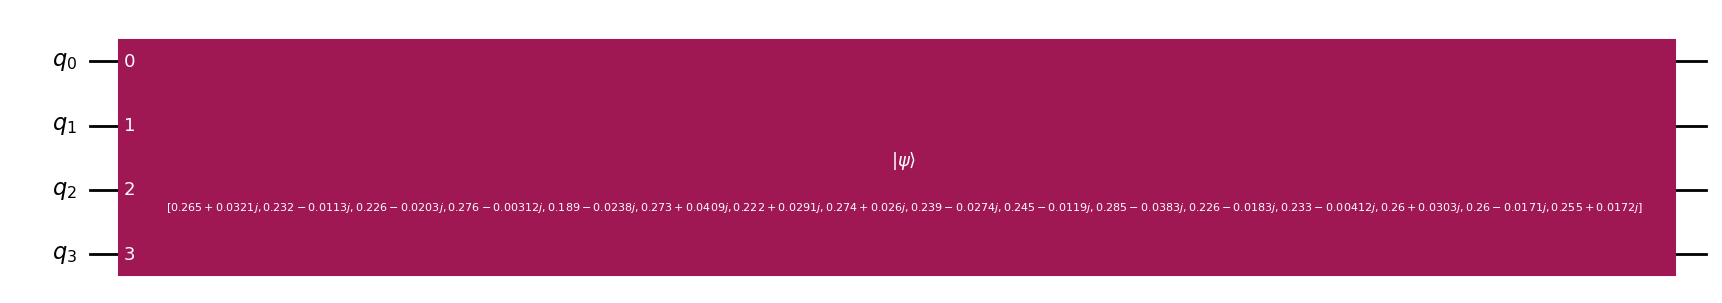

In [18]:
# Initial preparation
# 
circ = QuantumCircuit(qubits)
circ.initialize(q_mix_state_vec, circ.qubits) # initialize the mixed state
circ.draw('mpl')

## Current Stage(ITE): 

1. Qiskit Only provides Variational Quantum Imaginary Time evolution routine
2. The routine needs Ansatz to work on.
3. Qiskit provides convenience routines to work on the Ansatz, however, the proper choice is still remained.
4. Implement the ITE routine is required to work on the routine.

## Current Stage(Custom Grover Algorithm)